In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
def reset_graph(seed=None):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
    
def random_batch(X, y, batch_size):
    assert len(X) == len(y)
    rnd_idx = np.random.permutation(len(X))
    for idx in np.array_split(rnd_idx, batch_size):
        yield X[idx], y[idx]

#### Performing PCA with an Undercomplete Linear Autoencoder

In [5]:
np.random.seed(4)

w1, w2, noise = .1, .3, .1
m = 200
angle = np.random.rand(m) * np.pi*1.5 - 0.5

data = np.empty(shape=(m, 3), dtype=np.float32)

data[:, 0] = np.cos(angle) + np.sin(angle)*0.5 + noise*np.random.randn(m)*0.5
data[:, 1] = np.sin(angle) + 0.7*noise*np.random.randn(m)*0.5
data[:, 2] = data[:, 0] + w1*data[:, 1] + w2*noise*np.random.randn(m)*0.5

In [19]:
sc = StandardScaler()
X_train = sc.fit_transform(data[:100])
X_test = sc.transform(data[100:])

X_train.shape, X_test.shape

((100, 3), (100, 3))

In [20]:
reset_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

eta = .01

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32)
hidden = tf.layers.dense(X, n_hidden, activation=None)
outputs = tf.layers.dense(hidden, n_outputs, activation=None)

loss = tf.reduce_mean(tf.square(X - outputs))
optimizer = tf.train.AdamOptimizer(eta)
train_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [27]:
n_iters = 1001

with tf.Session() as sess:
    init.run()
    for i in range(n_iters):
        sess.run(train_op, feed_dict={X:X_train})
        if i%100==0:
            print("Iter {:4d}, tr-loss: {:.4f}".format(i, sess.run(loss, 
                                                                   feed_dict={X:X_train})))
    X_test_encoded = sess.run(hidden, feed_dict={X:X_test})

Iter    0, tr-loss: 1.9580
Iter  100, tr-loss: 0.2637
Iter  200, tr-loss: 0.1936
Iter  300, tr-loss: 0.0117
Iter  400, tr-loss: 0.0001
Iter  500, tr-loss: 0.0001
Iter  600, tr-loss: 0.0001
Iter  700, tr-loss: 0.0001
Iter  800, tr-loss: 0.0001
Iter  900, tr-loss: 0.0001
Iter 1000, tr-loss: 0.0001


In [22]:
X_test_encoded.shape

(100, 2)

Text(0.5,1,'2D projection with max variance')

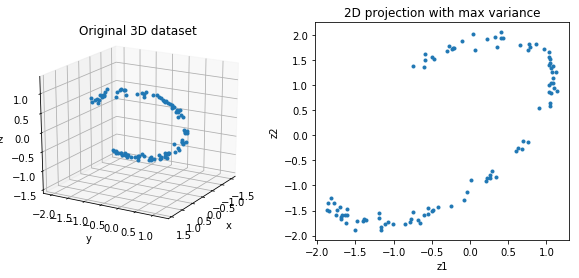

In [29]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.plot3D(X_test[:, 0], X_test[:, 1], X_test[:, 2], '.')
ax.view_init(elev=20, azim=30)
ax.set(xlabel='x', ylabel='y', zlabel='z')
ax.set_title('Original 3D dataset')

fig.add_subplot(122)
plt.plot(X_test_encoded[:, 0], X_test_encoded[:, 1], '.')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('2D projection with max variance')

#### Stacked Autoencoders

In [6]:
from keras.datasets.mnist import load_data
from functools import partial

Using TensorFlow backend.


In [7]:
(X_train, y_train), (X_test, y_test) = load_data()

In [8]:
X_train = X_train.reshape((len(X_train), -1)).astype(np.float32) / 255.
X_test = X_test.reshape((len(X_test), -1)).astype(np.float32) / 255.
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [9]:
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [91]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = .01
l2_reg = .0001

he_init = tf.variance_scaling_initializer()
l2 = tf.contrib.layers.l2_regularizer(l2_reg)

# pre-build dense layer with he_init, l2-reg, and elu activation
my_dense_layer = partial(tf.layers.dense, 
                         activation=tf.nn.elu, 
                         kernel_initializer=he_init, 
                         kernel_regularizer=l2)

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32)
h1 = my_dense_layer(X, n_hidden1)
h2 = my_dense_layer(h1, n_hidden2)
h3 = my_dense_layer(h2, n_hidden3)
outputs = my_dense_layer(h3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
total_loss = tf.add_n([reconstruction_loss] + reg_loss)

optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(total_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [76]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        tr_loss = []
        for X_batch, _ in random_batch(X_train, y_train, batch_size):
            _, loss_ = sess.run([train_op, total_loss], feed_dict={X:X_train})
            tr_loss.append(loss_)
        val_loss = np.mean([sess.run(total_loss, feed_dict={X:X_test_batch}) 
                            for X_test_batch, _ in random_batch(X_test, y_test, batch_size)])
        print("Epoch {:2d}, val-loss: {:.4f}, tr-loss: {:.4f}".format(epoch, val_loss, np.mean(tr_loss)))
    model_path = saver.save(sess, './my_mnist_autoencoder')

Epoch  0, val-loss: 0.0978, tr-loss: 0.1962
Epoch  1, val-loss: 0.0591, tr-loss: 0.0784
Epoch  2, val-loss: 0.0416, tr-loss: 0.0495
Epoch  3, val-loss: 0.0325, tr-loss: 0.0374
Epoch  4, val-loss: 0.0295, tr-loss: 0.0306


In [59]:
model_path

'./my_mnist_autoencoder'

In [143]:
def display_reconstruction(X_tf, output_tf, n_test, model_path=''):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        rnd_idx = np.random.randint(0, high=len(X_test), size=n_test)
        X_test_samples = X_test[rnd_idx]
        X_test_reconstruct = output_tf.eval(feed_dict={X_tf:X_test_samples})

    fig = plt.figure(figsize=(8, 3*n_test))
    for i in range(n_test):
        plt.subplot(n_test, 2, i*2+1)
        plt.imshow(X_test_samples[i].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.subplot(n_test, 2, i*2+2)
        plt.imshow(X_test_reconstruct[i].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')    

INFO:tensorflow:Restoring parameters from ./my_mnist_autoencoder


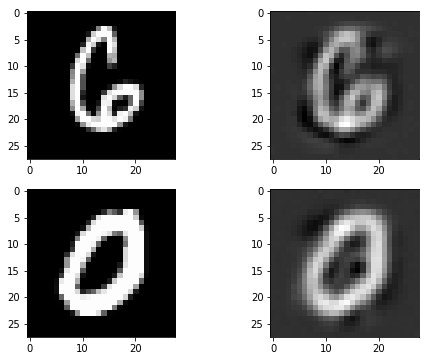

In [93]:
display_reconstruction(model_path='./my_mnist_autoencoder', X_tf=X, output_tf=outputs, n_test=2)

#### Tying Weights

In [95]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150    # coding layer
n_hidden3 = n_hidden1
n_outputs = n_inputs

eta = .001
l2_reg = .0005

activation_func = tf.nn.elu
he_init = tf.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')

# initialize value for weights: only encoding layers
W1_init = he_init(shape=(n_inputs, n_hidden1))
W2_init = he_init(shape=(n_hidden1, n_hidden2))

# initialize weights for each layers
W1 = tf.Variable(W1_init, dtype=tf.float32, name='weights1')    # [n_inputs, n_hidden1]
W2 = tf.Variable(W2_init, dtype=tf.float32, name='weights2')    # [n_hidden1, n_hidden2]
W3 = tf.transpose(W2, name='weights3')                          # [n_hidden2, n_hidden1]
W4 = tf.transpose(W1, name='weights4')                          # [n_hidden1, n_inputs]

# initialize biases for each layers
biases1 = tf.zeros(shape=(n_hidden1), dtype=tf.float32, name='biases1')
biases2 = tf.zeros(shape=(n_hidden2), dtype=tf.float32, name='biases2')
biases3 = tf.zeros(shape=(n_hidden3), dtype=tf.float32, name='biases3')
biases4 = tf.zeros(shape=(n_outputs), dtype=tf.float32, name='biases4')

# layer construction
hidden1 = activation_func(tf.matmul(X, W1) + biases1)
hidden2 = activation_func(tf.matmul(hidden1, W2) + biases2)
hidden3 = activation_func(tf.matmul(hidden2, W3) + biases3)
outputs = tf.matmul(hidden3, W4) + biases4

# training op
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(W1) + regularizer(W2)
total_loss = reg_loss + reconstruction_loss
optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train_op = optimizer.minimize(total_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [89]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        tr_loss = 0.
        for i, (X_batch, _) in enumerate(random_batch(X_train, y_train, batch_size)):
            loss_, _ = sess.run([reconstruction_loss, train_op], feed_dict={X:X_batch})
            tr_loss += loss_
        tr_loss /= (i+1)
        val_loss = np.mean([sess.run(reconstruction_loss, feed_dict={X:X_batch}) 
                           for X_batch, _ in random_batch(X_test, y_test, batch_size)])
        print("Epoch {:3d}, tr-loss: {:.4f}, val-loss: {:.4f}".format(epoch, tr_loss, val_loss))
    
    model_path = saver.save(sess, './my_mnist_tieweight_autoencoder')

Epoch   0, tr-loss: 0.0267, val-loss: 0.0184
Epoch   1, tr-loss: 0.0186, val-loss: 0.0180
Epoch   2, tr-loss: 0.0184, val-loss: 0.0180
Epoch   3, tr-loss: 0.0184, val-loss: 0.0180
Epoch   4, tr-loss: 0.0184, val-loss: 0.0180


INFO:tensorflow:Restoring parameters from ./my_mnist_tieweight_autoencoder


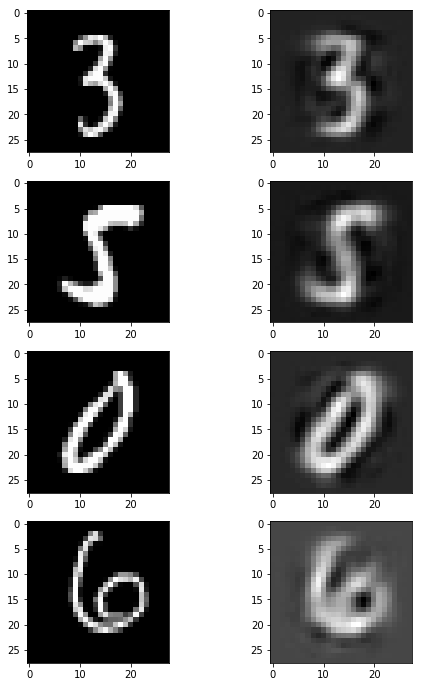

In [97]:
display_reconstruction(model_path, X, outputs, n_test=4)

#### Training one Autoencoder at a time in multiple graphs

In [119]:
reset_graph()

def train_autoencoder(X_inputs, n_neurons, 
                      hidden_activation = tf.nn.elu, 
                      output_activation = tf.nn.elu, 
                      l2_reg = .0005, learning_rate = .01, 
                      n_epochs = 10, batch_size = 64):

    n_inputs = X_inputs.shape[1]
    l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    he_init = tf.variance_scaling_initializer()
    
    g = tf.Graph()
    with g.as_default():
        # build graph: inputs -> hidden -> outputs
        X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32)

        hidden1 = tf.layers.dense(X, n_neurons, activation=hidden_activation, 
                                  kernel_initializer=he_init, 
                                  kernel_regularizer=l2_regularizer, 
                                  name='hidden')
        outputs = tf.layers.dense(hidden1, n_inputs, activation=output_activation, 
                                  kernel_initializer=he_init, 
                                  kernel_regularizer=l2_regularizer, 
                                  name='outputs')
        # training operation
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        mse_loss = tf.reduce_mean(tf.square(outputs - X))
        loss = tf.add_n([mse_loss] + reg_losses)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=g) as sess:
        init.run()
        for epoch in range(n_epochs):
            for X_batch, _ in random_batch(X_inputs, X_inputs, batch_size):
                sess.run(train_op, feed_dict={X:X_batch})
            tr_mse = sess.run(mse_loss, feed_dict={X:X_batch})
            print("Epoch {:3d}, tr-mse: {:.4f}".format(epoch, tr_mse))

        hidden_values = sess.run(hidden1, feed_dict={X:X_inputs})
        params = {var.name:var.eval() for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)}
        W1, b1 = params['hidden/kernel:0'], params['hidden/bias:0']
        W2, b2 = params['outputs/kernel:0'], params['outputs/bias:0']
    return hidden_values, W1, b1, W2, b2

In [120]:
h1_values, W1, b1, W4, b4 = train_autoencoder(X_train, n_neurons=300, n_epochs=5)
_, W2, b2, W3, b3 = train_autoencoder(h1_values, n_neurons=150, n_epochs=5)

Epoch   0, tr-mse: 0.0210
Epoch   1, tr-mse: 0.0180
Epoch   2, tr-mse: 0.0181
Epoch   3, tr-mse: 0.0174
Epoch   4, tr-mse: 0.0179
Epoch   0, tr-mse: 0.0082
Epoch   1, tr-mse: 0.0041
Epoch   2, tr-mse: 0.0038
Epoch   3, tr-mse: 0.0038
Epoch   4, tr-mse: 0.0038


In [121]:
W1.shape, W2.shape, W3.shape, W4.shape

((784, 300), (300, 150), (150, 300), (300, 784))

In [123]:
reset_graph()
X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32)
h1 = tf.nn.elu(tf.matmul(X, W1) + b1)
h2 = tf.nn.elu(tf.matmul(h1, W2)+ b2)
h3 = tf.nn.elu(tf.matmul(h2, W3) + b3)
outputs = tf.matmul(h3, W4) + b4

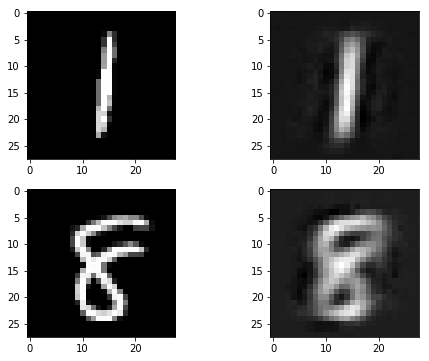

In [125]:
display_reconstruction(X, outputs, n_test=2)

#### Training one Autoencoder at a time in a single graph


In [132]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = .01
l2_reg = .0001

weight_init = tf.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
activation = tf.nn.elu

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32)

W1 = tf.Variable(weight_init(shape=[n_inputs, n_hidden1]), dtype=tf.float32, name='W1')
W2 = tf.Variable(weight_init([n_hidden1, n_hidden2]), dtype=tf.float32, name='W2')
W3 = tf.Variable(weight_init([n_hidden2, n_hidden3]), dtype=tf.float32, name='W3')
W4 = tf.Variable(weight_init([n_hidden3, n_outputs]), dtype=tf.float32, name='W4')

b1 = tf.Variable(tf.zeros(shape=[n_hidden1]), dtype=tf.float32, name='b1')
b2 = tf.Variable(tf.zeros(shape=[n_hidden2]), dtype=tf.float32, name='b2')
b3 = tf.Variable(tf.zeros(shape=[n_hidden3]), dtype=tf.float32, name='b3')
b4 = tf.Variable(tf.zeros(shape=[n_outputs]), dtype=tf.float32, name='b4')

h1 = activation(tf.matmul(X, W1) + b1)
h2 = activation(tf.matmul(h1, W2) + b2)
h3 = activation(tf.matmul(h2, W3) + b3)
outputs = tf.matmul(h3, W4) + b4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

with tf.name_scope('phase_1'):
    phase1_outputs = tf.matmul(h1, W4) + b4
    phase1_recon_loss = tf.reduce_mean(tf.square(X - phase1_outputs))
    phase1_reg_loss = regularizer(W1) + regularizer(W4)
    phase1_loss = phase1_recon_loss + phase1_reg_loss
    phase1_train_op = optimizer.minimize(phase1_loss)
    
with tf.name_scope('phase_2'):
    phase2_recon_loss = tf.reduce_mean(tf.square(h3 - h1))
    phase2_reg_loss = regularizer(W2) + regularizer(W3)
    phase2_loss = phase2_recon_loss + phase2_reg_loss
    phase2_train_vars = [W2, b2, W3, b3]
    phase2_train_op = optimizer.minimize(phase2_loss, var_list=phase2_train_vars)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [145]:
training_phase = [phase1_train_op, phase2_train_op]
losses = [phase1_loss, phase2_loss]
n_epochs = [20, 30]
batch_size = [150, 150]

with tf.Session() as sess:
    init.run()
    for i in range(len(training_phase)):
        print("training phase", i+1)
        for epoch in range(n_epochs[i]):
            for X_batch, _ in random_batch(X_train, X_train, batch_size[i]):
                sess.run(training_phase[i], feed_dict={X:X_batch})
            tr_loss = losses[i].eval(feed_dict={X:X_batch})
            print("Epoch {:2d}, tr-loss: {:.4f}".format(epoch, tr_loss))
        print('='*30)
    recon_loss = sess.run(reconstruction_loss, feed_dict={X:X_test})
    print("reconstruction test loss: {:.4f}".format(recon_loss))
    model_path = saver.save(sess, './my_mnist_2phase_autoencoder')

training phase 1
Epoch  0, tr-loss: 0.0337
Epoch  1, tr-loss: 0.0189
Epoch  2, tr-loss: 0.0159
Epoch  3, tr-loss: 0.0153
Epoch  4, tr-loss: 0.0150
Epoch  5, tr-loss: 0.0152
Epoch  6, tr-loss: 0.0146
Epoch  7, tr-loss: 0.0149
Epoch  8, tr-loss: 0.0149
Epoch  9, tr-loss: 0.0148
Epoch 10, tr-loss: 0.0151
Epoch 11, tr-loss: 0.0148
Epoch 12, tr-loss: 0.0148
Epoch 13, tr-loss: 0.0149
Epoch 14, tr-loss: 0.0148
Epoch 15, tr-loss: 0.0151
Epoch 16, tr-loss: 0.0152
Epoch 17, tr-loss: 0.0149
Epoch 18, tr-loss: 0.0149
Epoch 19, tr-loss: 0.0156
training phase 2
Epoch  0, tr-loss: 0.5743
Epoch  1, tr-loss: 0.2702
Epoch  2, tr-loss: 0.0603
Epoch  3, tr-loss: 0.0225
Epoch  4, tr-loss: 0.0159
Epoch  5, tr-loss: 0.0128
Epoch  6, tr-loss: 0.0114
Epoch  7, tr-loss: 0.0106
Epoch  8, tr-loss: 0.0102
Epoch  9, tr-loss: 0.0099
Epoch 10, tr-loss: 0.0098
Epoch 11, tr-loss: 0.0097
Epoch 12, tr-loss: 0.0096
Epoch 13, tr-loss: 0.0096
Epoch 14, tr-loss: 0.0096
Epoch 15, tr-loss: 0.0096
Epoch 16, tr-loss: 0.0096
Epoc

INFO:tensorflow:Restoring parameters from ./my_mnist_2phase_autoencoder


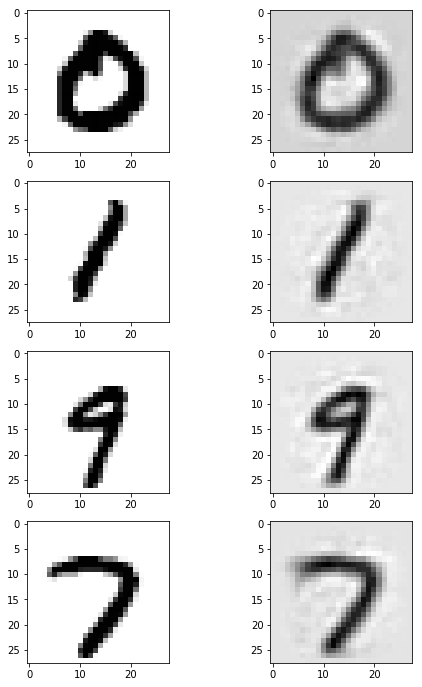

In [149]:
display_reconstruction(X, outputs, model_path=model_path, n_test=4)

#### Visualizing Features

In [150]:
model_path

'./my_mnist_2phase_autoencoder'

In [152]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    W1_values = W1.eval()

INFO:tensorflow:Restoring parameters from ./my_mnist_2phase_autoencoder


In [153]:
W1_values.shape

(784, 300)

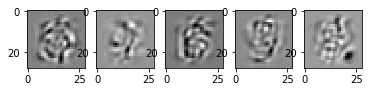

In [154]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(W1_values[:, i].reshape((28, 28)), cmap=plt.cm.gray_r)

#### Unsupervised Pretraining using Stacked Autoencoders

In [160]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = .01
l2_reg = .0005

activation = tf.nn.elu
weight_init = tf.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(None), dtype=tf.int32, name='y')

W1 = tf.Variable(weight_init(shape=[n_inputs, n_hidden1]),  dtype=tf.float32, name='W1')
b1 = tf.Variable(tf.zeros(shape=(n_hidden1)), dtype=tf.float32, name='b1')
W2 = tf.Variable(weight_init(shape=[n_hidden1, n_hidden2]), dtype=tf.float32, name='W2')
b2 = tf.Variable(tf.zeros(shape=(n_hidden2)), dtype=tf.float32, name='b2')
W3 = tf.Variable(weight_init(shape=[n_hidden2, n_outputs]), dtype=tf.float32, name='W3')
b3 = tf.Variable(tf.zeros(shape=(n_outputs)), dtype=tf.float32, name='b3')

h1 = activation(tf.matmul(X, W1) + b1)
h2 = activation(tf.matmul(h1, W2) + b2)
logits = tf.matmul(h2, W3) + b3

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
xentroy_loss = tf.reduce_mean(xentropy)
reg_loss = regularizer(W1) + regularizer(W2) + regularizer(W3)
loss = xentroy_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, k=1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
pretrain_saver = tf.train.Saver(var_list=[W1, W2, b1, b2])

In [166]:
n_epochs = 4
batch_size = 150
n_labels = 20000

n_labels_idx = np.random.permutation(len(X_train))[:n_labels]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train[n_labels_idx], y_train[n_labels_idx], batch_size):
            sess.run(train_op, feed_dict={X:X_batch, y:y_batch})
        tr_loss = xentroy_loss.eval(feed_dict={X:X_batch, y:y_batch})
        val_loss, val_acc = sess.run([xentroy_loss, accuracy], feed_dict={X:X_test, y:y_test})
        print("Epoch {:2d}, tr-loss: {:.4f}, val-loss: {:.4f}, val-acc: {:.4f}".format(epoch, 
                                                                                       tr_loss,
                                                                                       val_loss,
                                                                                       val_acc))

Epoch  0, tr-loss: 0.2379, val-loss: 0.2659, val-acc: 0.9164
Epoch  1, tr-loss: 0.1311, val-loss: 0.1902, val-acc: 0.9387
Epoch  2, tr-loss: 0.0762, val-loss: 0.1959, val-acc: 0.9395
Epoch  3, tr-loss: 0.0654, val-loss: 0.1905, val-acc: 0.9410


In [165]:
n_labels_idx

array([34182, 51785, 28253, ..., 34000, 56793, 47810])

In [167]:
# using pretrain autoencoder
n_epochs = 4
batch_size = 150

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, model_path)
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train[n_labels_idx], y_train[n_labels_idx], batch_size):
            sess.run(train_op, feed_dict={X:X_batch, y:y_batch})
        tr_loss = xentroy_loss.eval(feed_dict={X:X_batch, y:y_batch})
        val_loss, val_acc = sess.run([xentroy_loss, accuracy], feed_dict={X:X_test, y:y_test})
        print("Epoch {:2d}, tr-loss: {:.4f}, val-loss: {:.4f}, val-acc: {:.4f}".format(epoch, 
                                                                                       tr_loss,
                                                                                       val_loss,
                                                                                       val_acc))

INFO:tensorflow:Restoring parameters from ./my_mnist_2phase_autoencoder
Epoch  0, tr-loss: 0.1367, val-loss: 0.2363, val-acc: 0.9255
Epoch  1, tr-loss: 0.1505, val-loss: 0.1861, val-acc: 0.9415
Epoch  2, tr-loss: 0.1286, val-loss: 0.1687, val-acc: 0.9485
Epoch  3, tr-loss: 0.1776, val-loss: 0.1825, val-acc: 0.9463


#### Denoising Autoencoders

In [173]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

noise_level = 1.0
learning_rate = .005

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='inputs')
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))
h1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.elu, name='hidden1')
h2 = tf.layers.dense(h1, n_hidden2, activation=tf.nn.elu, name='hidden2')
h3 = tf.layers.dense(h2, n_hidden3, activation=tf.nn.elu, name='hidden3')
outputs = tf.layers.dense(h3, n_outputs, activation=None, name='outputs')

loss = tf.reduce_mean(tf.square(X - outputs))
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

encoded = h2

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [174]:
n_epochs = 10
batch_size = 150


with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, _ in random_batch(X_train, y_train, batch_size):
            sess.run(train_op, feed_dict={X:X_batch})
        tr_loss = sess.run(loss, feed_dict={X:X_batch})
        val_loss = sess.run(loss, feed_dict={X:X_test})
        print("Epoch {:2d}, tr-loss: {:.4f}, val-loss: {:.4f}".format(epoch, tr_loss, val_loss))
    model_path = saver.save(sess, './my_mnist_denoising_autoencoder')

Epoch  0, tr-loss: 0.0352, val-loss: 0.0357
Epoch  1, tr-loss: 0.0327, val-loss: 0.0328
Epoch  2, tr-loss: 0.0313, val-loss: 0.0316
Epoch  3, tr-loss: 0.0306, val-loss: 0.0305
Epoch  4, tr-loss: 0.0297, val-loss: 0.0299
Epoch  5, tr-loss: 0.0299, val-loss: 0.0297
Epoch  6, tr-loss: 0.0297, val-loss: 0.0292
Epoch  7, tr-loss: 0.0291, val-loss: 0.0291
Epoch  8, tr-loss: 0.0290, val-loss: 0.0286
Epoch  9, tr-loss: 0.0297, val-loss: 0.0287


INFO:tensorflow:Restoring parameters from ./my_mnist_denoising_autoencoder


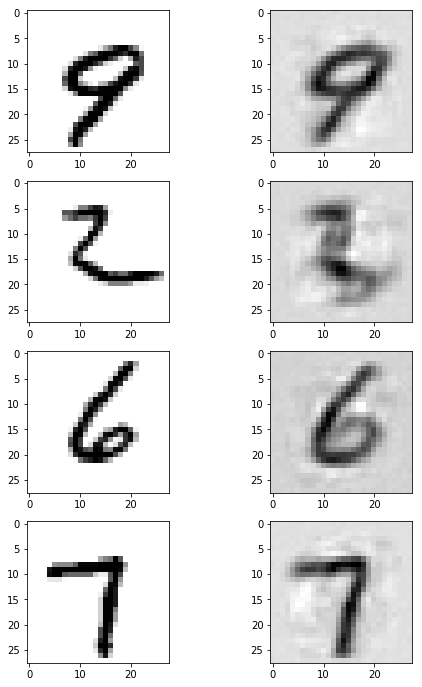

In [177]:
display_reconstruction(X, outputs, n_test=4, model_path=model_path)

In [181]:
# using dropout
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = .01
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')
X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='inputs')
X_dropout = tf.layers.dropout(X, rate=dropout_rate, training=training)
h1 = tf.layers.dense(X_dropout, n_hidden1, activation=tf.nn.elu, name='hidden1')
h2 = tf.layers.dense(h1, n_hidden2, activation=tf.nn.elu, name='hidden2')
h3 = tf.layers.dense(h2, n_hidden3, activation=tf.nn.elu, name='hidden3')
outputs = tf.layers.dense(h3, n_outputs, activation=None, name='outputs')

loss = tf.reduce_mean(tf.square(X - outputs))
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [182]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, _ in random_batch(X_train, y_train, batch_size):
            sess.run(train_op, feed_dict={X:X_batch, training:True})
        tr_mse = sess.run(loss, feed_dict={X:X_batch})
        val_mse = sess.run(loss, feed_dict={X:X_test})
        print("Epoch {:2d}, tr-loss: {:.4f}, val-loss: {:.4f}".format(epoch, tr_mse, val_mse))
    model_path = saver.save(sess, './my_mnist_denoising_dropout_autoencoder')

Epoch  0, tr-loss: 0.0440, val-loss: 0.0439
Epoch  1, tr-loss: 0.0354, val-loss: 0.0353
Epoch  2, tr-loss: 0.0300, val-loss: 0.0301
Epoch  3, tr-loss: 0.0275, val-loss: 0.0268
Epoch  4, tr-loss: 0.0248, val-loss: 0.0246
Epoch  5, tr-loss: 0.0235, val-loss: 0.0225
Epoch  6, tr-loss: 0.0214, val-loss: 0.0216
Epoch  7, tr-loss: 0.0216, val-loss: 0.0218
Epoch  8, tr-loss: 0.0200, val-loss: 0.0198
Epoch  9, tr-loss: 0.0174, val-loss: 0.0175


INFO:tensorflow:Restoring parameters from ./my_mnist_denoising_dropout_autoencoder


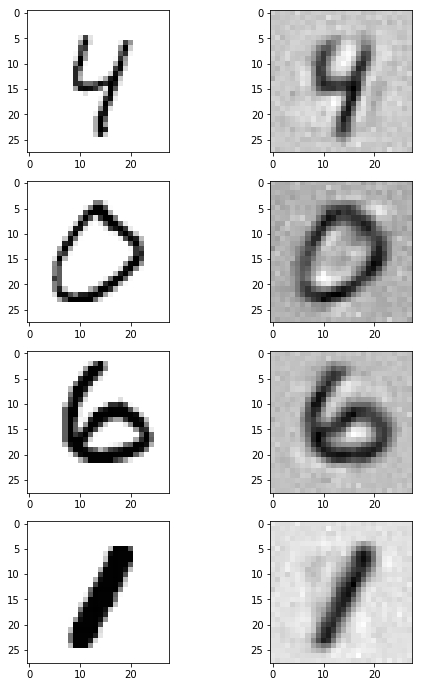

In [184]:
display_reconstruction(X, outputs, 4, model_path)

#### Sparse Autoencoders

In [197]:
reset_graph()

n_inputs = 28*28
n_hidden = 1000       # sparse codings
n_outputs = n_inputs

learning_rate = .01
sparsity_target = .1
sparsity_weight = .2

def kl_divergence(p, q):
    return p*tf.log(p/q) + (1-p)*tf.log((1-p)/(1-q))


X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32)
h1 = tf.layers.dense(X, n_hidden, activation=tf.nn.sigmoid, name='h1')
h1_mean = tf.reduce_mean(h1, axis=0)
logits = tf.layers.dense(h1, n_outputs, activation=None, name='logits')
outputs = tf.nn.sigmoid(logits)

sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, h1_mean))
entropy_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits))
total_loss = entropy_loss + sparsity_loss*sparsity_weight

optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(total_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [198]:
n_epochs = 20
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, _ in random_batch(X_train, y_train, batch_size):
            sess.run(train_op, feed_dict={X:X_batch})
        s_loss, e_loss, t_loss = sess.run([sparsity_loss, entropy_loss, total_loss], 
                                          feed_dict={X:X_batch})
        print('Epoch {:3d}, sparsity-loss: {:.3f}, entropy-loss: {:.3f}, total-loss: {:.3f}'.format(epoch,
                                                                                                    s_loss, e_loss,
                                                                                                    t_loss))
    model_path = saver.save(sess, './my_mnist_spase_autoencoder')

Epoch   0, sparsity-loss: 0.141, entropy-loss: 0.222, total-loss: 0.251
Epoch   1, sparsity-loss: 0.162, entropy-loss: 0.165, total-loss: 0.197
Epoch   2, sparsity-loss: 0.092, entropy-loss: 0.133, total-loss: 0.151
Epoch   3, sparsity-loss: 0.148, entropy-loss: 0.116, total-loss: 0.145
Epoch   4, sparsity-loss: 0.127, entropy-loss: 0.105, total-loss: 0.131
Epoch   5, sparsity-loss: 0.265, entropy-loss: 0.097, total-loss: 0.151
Epoch   6, sparsity-loss: 0.166, entropy-loss: 0.093, total-loss: 0.126
Epoch   7, sparsity-loss: 0.425, entropy-loss: 0.093, total-loss: 0.178
Epoch   8, sparsity-loss: 0.292, entropy-loss: 0.089, total-loss: 0.147
Epoch   9, sparsity-loss: 1.052, entropy-loss: 0.084, total-loss: 0.295
Epoch  10, sparsity-loss: 0.269, entropy-loss: 0.086, total-loss: 0.140
Epoch  11, sparsity-loss: 0.325, entropy-loss: 0.085, total-loss: 0.150
Epoch  12, sparsity-loss: 0.240, entropy-loss: 0.082, total-loss: 0.130
Epoch  13, sparsity-loss: 0.298, entropy-loss: 0.084, total-loss

INFO:tensorflow:Restoring parameters from ./my_mnist_spase_autoencoder


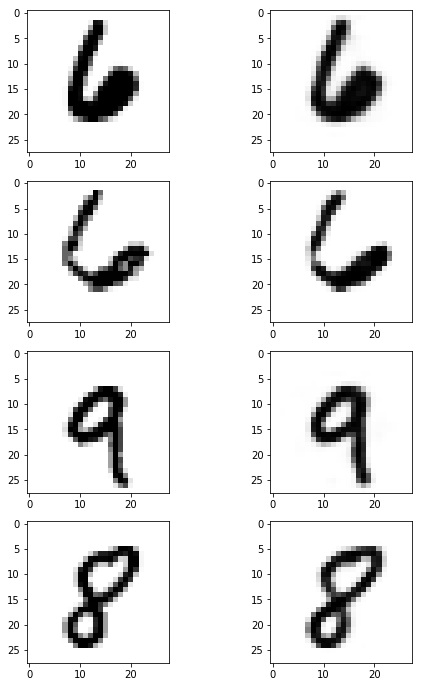

In [199]:
display_reconstruction(X, outputs, 4, model_path)

In [200]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    h_mean = h1_mean.eval(feed_dict={X:X_batch})


INFO:tensorflow:Restoring parameters from ./my_mnist_spase_autoencoder


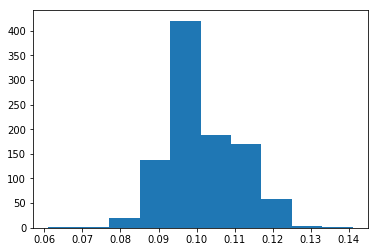

In [201]:
plt.hist(h_mean)
plt.show()

In [202]:
h_mean.mean()

0.10139677

#### Variational Autoencoders

In [5]:
reset_graph()

from functools import partial

n_inputs = 28*28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20     # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

eps = 1e-10
learning_rate = .001

he_init = tf.variance_scaling_initializer()
my_layer = partial(tf.layers.dense, 
                   kernel_initializer=he_init, 
                   activation=tf.nn.elu)

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32)
h1 = my_layer(X, n_hidden1)
h2 = my_layer(h1, n_hidden2)

h3_mean = my_layer(h2, n_hidden3, activation=None)
h3_sigma = my_layer(h2, n_hidden3, activation=None)
h3_noise = tf.random_normal(shape=tf.shape(h3_sigma))
h3 = h3_mean + h3_sigma*h3_noise

h4 = my_layer(h3, n_hidden4)
h5 = my_layer(h4, n_hidden5)
logits = my_layer(h5, n_outputs, activation=None)
outputs = tf.nn.sigmoid(logits)

reconstruction_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X))
latent_loss = 0.5*tf.reduce_sum(tf.square(h3_sigma) + tf.square(h3_mean) 
                                - 1 - tf.log(eps + tf.square(h3_sigma)))
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [212]:
epochs = 120
batch_size = 128

with tf.Session() as sess:
    init.run()
    for epoch in range(epochs):
        for X_batch, _ in random_batch(X_train, y_train, batch_size):
            sess.run(train_op, feed_dict={X:X_batch})
        
        if epoch%10==0:
            val_loss, val_recon_loss, val_latent_loss = sess.run([loss, reconstruction_loss, latent_loss], 
                                                            feed_dict={X:X_test})
            print("Epoch {:2d}, loss: {:.3f}, recon-loss: {:.3f}, latent-loss: {:.3f}".format(epoch, val_loss,
                                                                                          val_recon_loss,
                                                                                          val_latent_loss))
    model_path = saver.save(sess, './my_mnist_VAE')

Epoch  0, loss: 1815357.500, recon-loss: 1538982.125, latent-loss: 276375.375
Epoch 10, loss: 1157498.625, recon-loss: 945641.875, latent-loss: 211856.797
Epoch 20, loss: 1048745.750, recon-loss: 828680.688, latent-loss: 220065.125
Epoch 30, loss: 1018639.000, recon-loss: 790032.438, latent-loss: 228606.562
Epoch 40, loss: 1007063.500, recon-loss: 774061.312, latent-loss: 233002.156
Epoch 50, loss: 1050319.250, recon-loss: 804601.688, latent-loss: 245717.578
Epoch 60, loss: 993499.125, recon-loss: 766991.188, latent-loss: 226507.969
Epoch 70, loss: 1024345.500, recon-loss: 791437.188, latent-loss: 232908.281
Epoch 80, loss: 1133001.250, recon-loss: 897820.125, latent-loss: 235181.094
Epoch 90, loss: 1007348.875, recon-loss: 772875.000, latent-loss: 234473.906
Epoch 100, loss: 984898.000, recon-loss: 745416.750, latent-loss: 239481.250
Epoch 110, loss: 1050712.750, recon-loss: 816445.312, latent-loss: 234267.375


In [213]:
model_path

'./my_mnist_VAE'

INFO:tensorflow:Restoring parameters from ./my_mnist_VAE


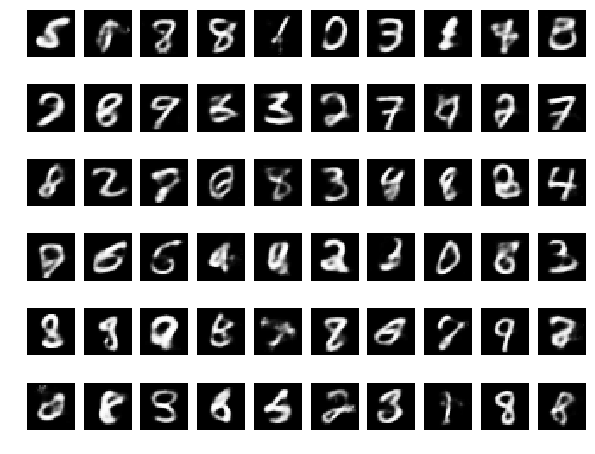

In [220]:
n_digits = 60
with tf.Session() as sess:
    saver.restore(sess, model_path)
    z = np.random.normal(size=(n_digits, n_hidden3))
    z_val = sess.run(outputs, feed_dict={h3:z})

fig = plt.figure(figsize=(10, 8))
for i in range(n_digits):
    plt.subplot(6, 10, i+1)
    plt.imshow(z_val[i].reshape((28, 28)), cmap=plt.cm.gray)
    plt.axis('off')

In [20]:
n_sample = 8
idx = np.random.permutation(len(X_test))[:n_sample]
im_samples = X_test[idx]
label_samples = y_test[idx]
label_samples

array([5, 2, 2, 2, 8, 8, 4, 2])

In [21]:
# encoding
with tf.Session() as sess:
    saver.restore(sess, './my_mnist_VAE')
    im_encoded = sess.run(h3, feed_dict={X:im_samples})

INFO:tensorflow:Restoring parameters from ./my_mnist_VAE


In [22]:
im_encoded.shape

(8, 20)

In [23]:
# decoding
with tf.Session() as sess:
    saver.restore(sess, './my_mnist_VAE')
    im_decoded = sess.run(outputs, feed_dict={h3:im_encoded})

INFO:tensorflow:Restoring parameters from ./my_mnist_VAE


In [24]:
im_decoded.shape

(8, 784)

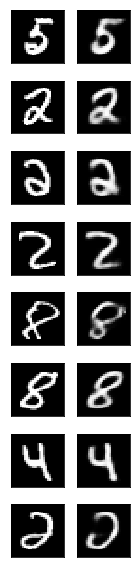

In [27]:
fig, ax = plt.subplots(nrows=n_sample, ncols=2, subplot_kw={'xticks':[], 'yticks':[]}, 
                       figsize=(2, n_sample))

for im_input, im_decode, axi in zip(im_samples, im_decoded, ax):
    axi[0].imshow(im_input.reshape((28, 28)), cmap=plt.cm.gray)
    axi[1].imshow(im_decode.reshape((28, 28)), cmap=plt.cm.gray)
    
fig.tight_layout()